In [313]:
# tf.test.gpu_device_name()
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu 
# !pip install tf-nightly

In [314]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [315]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [316]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [317]:
NUM_CLASSES = 10 #increment when adding the gestures

# Dataset reading

In [318]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [319]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [321]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [322]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_20 (Dropout)        (None, 42)                0         
                                                                 
 dense_30 (Dense)            (None, 20)                860       
                                                                 
 dropout_21 (Dropout)        (None, 20)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                210       
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [323]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [324]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [325]:
history=model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback]
)

Epoch 1/1000
 1/15 [=>............................] - ETA: 4s - loss: 2.2948 - accuracy: 0.1406
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
15/15 [==============================] - 1s 16ms/step - loss: 2.2953 - accuracy: 0.1201 - val_loss: 2.2872 - val_accuracy: 0.1368
Epoch 2/1000
 1/15 [=>............................] - ETA: 0s - loss: 2.2792 - accuracy: 0.1484
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
15/15 [==============================] - 0s 7ms/step - loss: 2.2712 - accuracy: 0.1411 - val_loss: 2.2489 - val_accuracy: 0.2767
Epoch 3/1000
 1/15 [=>............................] - ETA: 0s - loss: 2.2465 - accuracy: 0.1719
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
15/15 [==============================] - 0s 7ms/step - loss: 2.2381 - accuracy: 0.1877 - val_loss: 2.2078 - val_accuracy: 0.3160
Epoch 4/1000
 1/15 [=>............................] - ETA: 0s - loss: 2.2182 - accuracy: 0.2188


In [326]:
import matplotlib.pyplot as plt

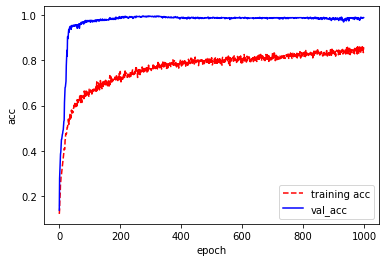

In [327]:


accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(len(accuracy))
plt.plot(epochs, accuracy,"r--")
plt.plot(epochs, val_accuracy,"b")
plt.legend(['training acc','val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

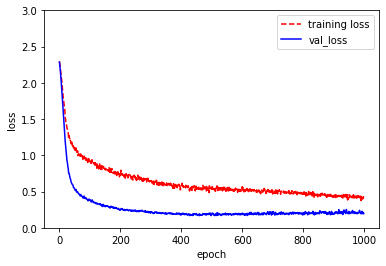

In [328]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss,"r--")
plt.plot(epochs, val_loss,"b")
plt.legend(['training loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,3)
plt.show()

In [329]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 3ms/step - loss: 0.1951 - accuracy: 0.9890


In [330]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [331]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 44ms/step
[4.0372955e-03 5.5607343e-03 1.6059419e-04 2.9095220e-03 6.1242529e-03
 7.7167493e-01 8.5645571e-02 9.3616704e-03 9.2584297e-02 2.1941172e-02]
5


# Confusion matrix

20/20 [==============================] - 0s 1ms/step


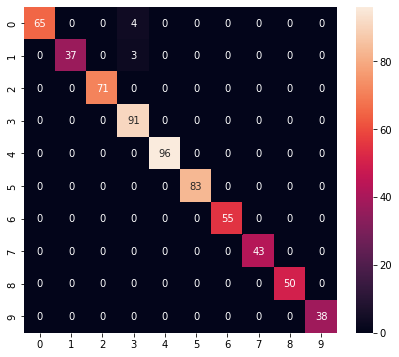

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        69
           1       1.00      0.93      0.96        40
           2       1.00      1.00      1.00        71
           3       0.93      1.00      0.96        91
           4       1.00      1.00      1.00        96
           5       1.00      1.00      1.00        83
           6       1.00      1.00      1.00        55
           7       1.00      1.00      1.00        43
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        38

    accuracy                           0.99       636
   macro avg       0.99      0.99      0.99       636
weighted avg       0.99      0.99      0.99       636



In [332]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [333]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [334]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6832

# Inference test

In [335]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [336]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [337]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [338]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.61 ms, sys: 0 ns, total: 1.61 ms
Wall time: 2.29 ms


In [339]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.0372978e-03 5.5607157e-03 1.6059342e-04 2.9095111e-03 6.1242473e-03
 7.7167493e-01 8.5645601e-02 9.3616443e-03 9.2584297e-02 2.1941176e-02]
5
